In [1]:
# General purpose imports to handle paths, files etc
import os
import os.path as op
import glob
import pandas as pd
import numpy as np
import json
import requests
import urllib.request
from tqdm import tqdm
# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

import nibabel as nib

def reset_overlays():
    """
    Clears view and completely remove visualization. All files opened in FSLeyes are closed.
    The view (along with any color map) is reset to the regular ortho panel.
    """
    l = frame.overlayList
    while(len(l)>0):
        del l[0]
    frame.removeViewPanel(frame.viewPanels[0])
    # Put back an ortho panel in our viz for future displays
    frame.addViewPanel(OrthoPanel)
    
def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')
        
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data
#bids_root

def open_subject_dataset(dataset_id, subject, download = False):
    sub = f'sub-{subject}'
    sample_path = "dataset"
    mkdir_no_exist(sample_path)
    bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)
    mkdir_no_exist(bids_root)

    #Derivatives folder to store masks and preprocessing garbage
    mkdir_no_exist(op.join(bids_root, 'derivatives'))
    preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
    mkdir_no_exist(preproc_root)
    mkdir_no_exist(op.join(preproc_root, sub))
    mkdir_no_exist(op.join(preproc_root, sub, 'anat'))
    mkdir_no_exist(op.join(preproc_root, sub, 'func'))
    mkdir_no_exist(op.join(preproc_root, sub, 'fmap'))
    
    if (download):
        os.system(f"rm {bids_root}/dataset_description.json")
        os.system("""openneuro-py download --dataset {} --include sub-{}/anat/* 
             --include sub-{}/func/sub-{}_task-flanker_run-1_bold.nii.gz 
             --include sub-{}/func/sub-{}_task-flanker_run-2_bold.nii.gz 
              --target_dir {}""".format(dataset_id, subject, subject, subject, subject, subject, bids_root).replace("\n", " "))
    
    print(f"Loaded {dataset_id} for {sub}")
    return bids_root, preproc_root

def perform_default_moco(subject, cost_func = "normcorr"):
    runs=2
    sub = f'sub-{subject}'
    for r in range(runs):
        path_original_data = os.path.join(bids_root, sub, 'func', f'{sub}_task-flanker_run-{r+1}_bold')
        path_moco_data = os.path.join(preproc_root, sub, 'func', f'{sub}_task-flanker_run-{r+1}_bold_moco_{cost_func}')
        mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True, cost = cost_func)


def load_mot_params_fsl_6_dof(subject, cost_func = "normcorr"):
    path=op.join(preproc_root, f'sub-{subject}', 'func', f'sub-{subject}_task-flanker_run-{flanker_run}_bold_moco_{cost_func}.par')
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

def visualize_motparams(data):
    fig, ax = plt.subplots(3,2, figsize = (9, 8))
    for cdx, c in enumerate(data.columns.tolist()):
        ax[cdx%3, int(cdx/3)].plot(data[c], color = ["royalblue", "tomato"][int(cdx/3)])
        ax[cdx%3, int(cdx/3)].set_xlabel("Volumes")
        ax[cdx%3,int(cdx/3)].set_ylabel("Motion (mm)")
        ax[cdx%3,int(cdx/3)].set_title(c)
    plt.tight_layout()
    fig.suptitle(f"Flanker Run {flanker_run}", y = 1.02) 
    plt.show()

def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

def visualise_fd(fd, subject):
    threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
    plt.plot(list(range(1, fd.size+1)), fd)
    plt.title(f"Framewise Displacement (FD) for all the volumes of Flanker Run {flanker_run} for sub-{subject}")
    plt.xlabel('Volume')
    plt.ylabel('FD displacement (mm)')
    plt.hlines(threshold, 0, 150,colors='black', linestyles='dashed', label='FD threshold')
    plt.legend()
    plt.show()

# Compute RMS Movement from Transformation Parameters:
def calculate_rms_movement(subject):
    par_file=op.join(preproc_root, f'sub-{subject}', 'func', f'sub-{subject}_task-flanker_run-{flanker_run}_bold_moco.par')
    # Load motion parameters from the .par file
    motion_params = np.genfromtxt(par_file)
    # Extract translation parameters (mm)
    translation_params = motion_params[:, 3:6]
    # Calculate the RMS movement for each time point
    rms_movement = np.sqrt(np.sum(translation_params**2, axis=1))
    average_rms_movement = np.mean(rms_movement)
    return average_rms_movement

def visualize_motparams_oneplot(data):
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ['r', 'g', 'b']
    
    for i, coord in enumerate(['x', 'y', 'z']):
        rotation_col = f'Rotation {coord}'
        translation_col = f'Translation {coord}'

        ax.plot(data.index, data[rotation_col], label=f'Rotation {coord}', linestyle='--', color=colors[i])
        ax.plot(data.index, data[translation_col], label=f'Translation {coord}', color=colors[i])

    ax.set_xlabel('Time')
    ax.set_ylabel('Values (mm)')
    ax.set_title('Rotation and Translation Data')
    ax.legend()
    plt.grid()
    plt.show()

def calculate_rms_movement_path(path):
    par_file=op.join(preproc_root, f'sub-{subject}', 'func', path)
    # Load motion parameters from the .par file
    motion_params = np.genfromtxt(par_file)
    # Extract translation parameters (mm)
    translation_params = motion_params[:, 3:6]
    # Calculate the RMS movement for each time point
    rms_movement = np.sqrt(np.sum(translation_params**2, axis=1))
    average_rms_movement = np.mean(rms_movement)
    return average_rms_movement
    
def load_mot_params_fsl_6_dof_path(path):
    path=op.join(preproc_root, f'sub-{subject}', 'func', path)
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

def generate_mean_functional(input_path, output_path):
    os.system('fslmaths {} -Tmean {}'.format(input_path, output_path))
    print('Mean functional image generated successfully')

def perform_mean_moco(subject, cost_func = "normcorr"):
    runs=2
    sub = f'sub-{subject}'
    for r in range(runs):
        path_original_data = os.path.join(bids_root, sub, 'func', f'{sub}_task-flanker_run-{r+1}_bold')
        output_mean_path = os.path.join(preproc_root, sub, 'func', f'{sub}_task-flanker_run-{r+1}_bold_mean')
        output_moco_mean_path = os.path.join(preproc_root, sub, 'func', f'{sub}_task-flanker_run-{r+1}_bold_moco_mean_{cost_func}')
        generate_mean_functional(path_original_data, output_mean_path)
        mcflirt(infile=path_original_data,o=output_moco_mean_path, refvol = output_mean_path, plots=True, report=True, dof=6,
                mats=True, cost = cost_func)
    print("Mean moco applied successfully")
    
def load_mean_mot_params_fsl_6_dof(subject, cost_func = "normcorr"):
    path=op.join(preproc_root, f'sub-{subject}', 'func', f'sub-{subject}_task-flanker_run-{flanker_run}_bold_moco_mean_{cost_func}.par')
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])


In [ ]:
# Useful imports to define the direct download function below
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

# MINI PROJECT 1: Variant 2, Motion Correction

## Part 1: Visualizing Data

Visualise the anatomical scan and functional scan. Make an animation of the
anatomical scan and functional scan

In [2]:
dataset_id = 'ds000102' 
flanker_run = 1
sub = "sub-06"
bids_root, preproc_root = open_subject_dataset(dataset_id, subject='06', download=False)

In [12]:
print_dir_tree(bids_root, max_depth=3)

|ds000102/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-06/
|--------- sub-07/
|--------- sub-08/
|--- sub-06/
|------ anat/
|--------- sub-06_T1w.nii.gz
|------ func/
|--------- sub-06_task-flanker_run-1_bold.nii.gz
|--------- sub-06_task-flanker_run-2_bold.nii.gz


In [3]:
#Anatomical scan
reset_overlays()
load(op.join(bids_root, sub, 'anat', 'sub-06_T1w.nii.gz'))

Image(sub-06_T1w, /Users/leger/Desktop/@/python/nssp/NSSP_Mini1/dataset/ds000102/sub-06/anat/sub-06_T1w.nii.gz)

In [4]:
#Functional scans
reset_overlays()
load(op.join(bids_root, sub, 'func', 'sub-06_task-flanker_run-1_bold.nii.gz'))
load(op.join(bids_root, sub, 'func', 'sub-06_task-flanker_run-2_bold.nii.gz'))

Image(sub-06_task-flanker_run-2_bold, /Users/leger/Desktop/@/python/nssp/NSSP_Mini1/dataset/ds000102/sub-06/func/sub-06_task-flanker_run-2_bold.nii.gz)

## Part 2: Brain extraction
Perform brain extraction on the anatomical image using FSL. Perform brain extraction for different fractional intensity threshold and comment on your observations

In [5]:
reset_overlays()
load(op.join(bids_root, sub, 'anat', 'sub-06_T1w.nii.gz'))

Image(sub-06_T1w, /Users/leger/Desktop/@/python/nssp/NSSP_Mini1/dataset/ds000102/sub-06/anat/sub-06_T1w.nii.gz)

In [6]:
anatomical_path = op.join(bids_root, sub, 'anat', 'sub-06_T1w.nii.gz')
fractional_intensities = np.arange(0, 9/8, 1/8)
masks = []
for fdx, fi in enumerate(fractional_intensities):
    
    betted_brain_path = op.join(preproc_root, sub, 'anat', f'sub-06_T1w_fi_{int(100*fi)}')
    masks.append(op.join(preproc_root, sub, 'anat', f'sub-06_T1w_fi_{int(100*fi)}_mask'))
    bet(anatomical_path, betted_brain_path, mask=masks[-1], robust = True, fracintensity = fi)
    
    print(f"Done {round(100*(fdx+1)/len(fractional_intensities), 1)} %") 

In [7]:
for m in masks:
    load(m + ".nii.gz")

Upon changing the fractional intensity threshold, we notice major differences in BET. 
- 0 fractional intensity tends to take the whole volume as a mask 
- 1 FI fails completely at masking the gray and some white matter. 
- The best FI's seem to be in the 0.25-0.5 range. 

In BET, the fractional intensity threshold ("f") is used to determine the intensity value below which voxels are considered to be outside the brain. Voxels in the brain typically have higher intensity values than those outside the brain (e.g., in the skull or surrounding tissues).

f-parameter represents a fraction or proportion of the maximum intensity value in the image. In other words, it's a threshold relative to the maximum intensity in the image. When you set the "f" parameter in BET, the tool calculates the threshold intensity value by multiplying "f" with the maximum intensity in the image. Voxels with intensities below this threshold are considered non-brain tissue.

### Part-3: Motion correction


1) Compute and visualize the motion parameters for 6-dof, i.e., 3 Rotations + 3 Translations across all the volumes. and visualize the motion parameters for 6-dof, i.e., 3 Rotations + 3 Translations across all the volumes.

In [6]:
perform_default_moco(subject='06', cost_func = 'mutualinfo')

'RMS movement: '

0.09599096029493608

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.002773,-0.002140,-1.516060e-07,0.001120,-0.012713,-0.179451
1,-0.002771,-0.001939,-1.552420e-04,-0.004814,-0.017364,-0.137876
2,-0.002130,-0.001985,6.264060e-05,-0.008075,0.016453,-0.142414
3,-0.001850,-0.002229,6.264060e-05,0.008051,0.004412,-0.106520
4,-0.001832,-0.002329,6.264060e-05,-0.005154,0.013448,-0.106621


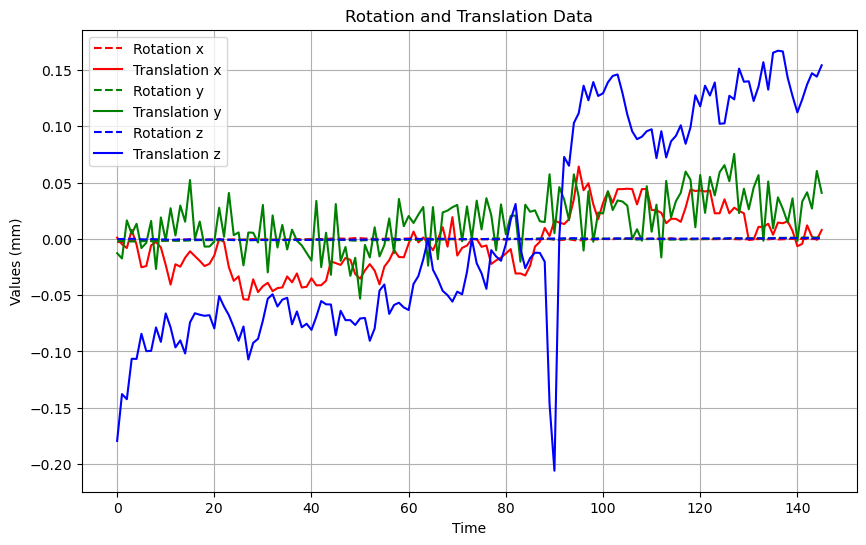

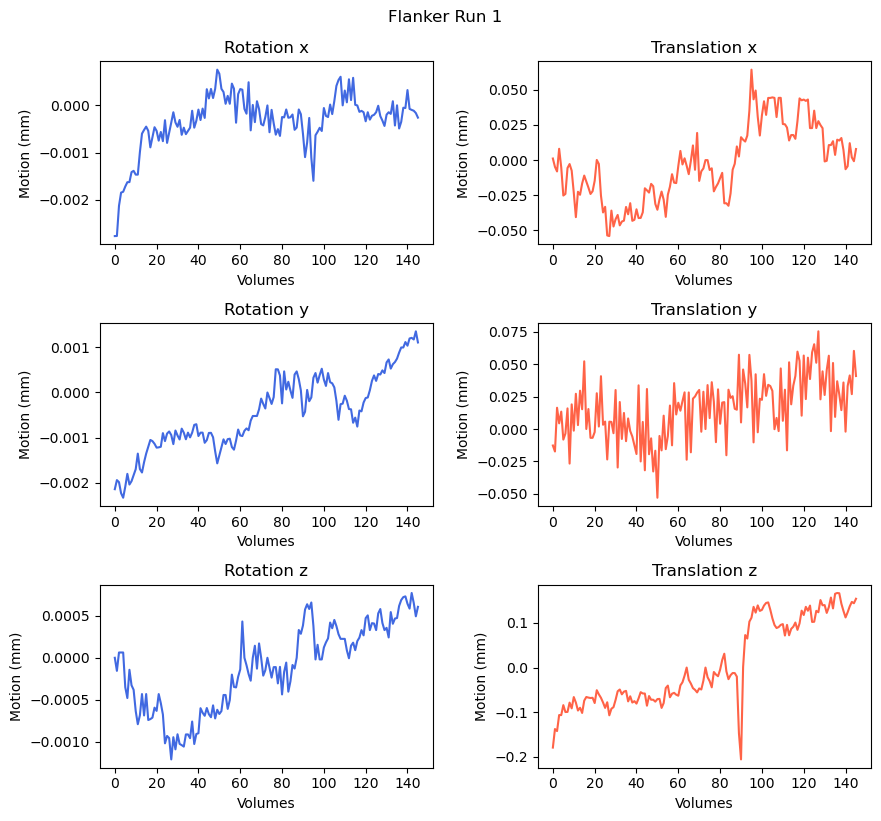

In [8]:
reset_overlays()
load(os.path.join(bids_root, sub, 'func', 'sub-06_task-flanker_run-1_bold.nii.gz'))
load(os.path.join(preproc_root, sub, 'func', 'sub-06_task-flanker_run-1_bold_moco.nii.gz'))


%matplotlib inline
mot_params = load_mot_params_fsl_6_dof(subject='06', cost_func = 'mutualinfo')
display("RMS movement: ", calculate_rms_movement(subject='06'))
display(mot_params.head())

visualize_motparams_oneplot(mot_params)
visualize_motparams(mot_params)

2) Compute and visualize the Framewise Displacement (FD) for all the volumes

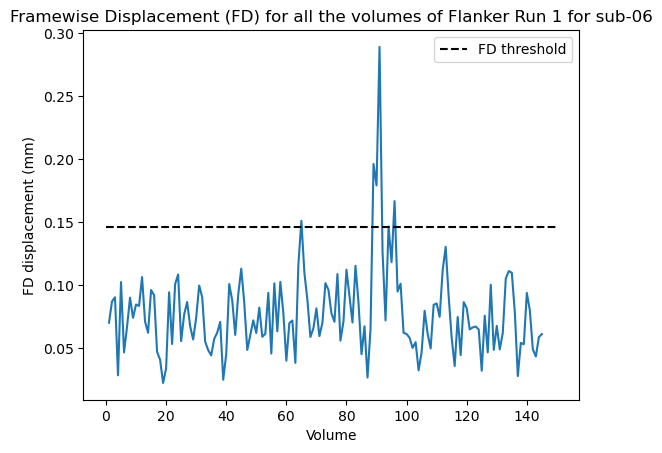

In [9]:
%matplotlib inline
fd_06 = compute_FD_power(mot_params).to_numpy()
visualise_fd(fd_06, '06')

3) Apply motion correction on your data (mcflirt settings: use default cost function,
reference volume as middle volume) and visualize the result for a volume of your
choice (other than the middle volume).

In [3]:
#Basic motion correction
run = 1
subject = "06"
sub = f'sub-{subject}'
path_original_data = os.path.join(bids_root, sub, 'func', f'{sub}_task-flanker_run-{run}_bold')
path_moco_data = os.path.join(preproc_root, sub, 'func', f'{sub}_task-flanker_run-{run}_bold_moco')
#normcorr is default
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True, cost = "normcorr")

{}

In [10]:
#We chose for our visualization, volumne of choice, the one with maximum FD displacement, 
volume_of_choice = np.argmax(fd_06)
display("volume of choice = ", volume_of_choice) 
img_bold = nib.load(os.path.join(bids_root, sub, 'func', 'sub-06_task-flanker_run-1_bold.nii.gz'))
img_moco = nib.load(os.path.join(preproc_root, sub, 'func', 'sub-06_task-flanker_run-1_bold_moco.nii.gz'))

data_bold = img_bold.get_fdata()
data_moco= img_moco.get_fdata()

'volume of choice = '

90

'% Voxels with non-null corrections: 75.35'

'% Brain voxels with low intensity corrections (< 5): 51.12'

Text(0.5, 0, '$\\Delta$ Intensity')

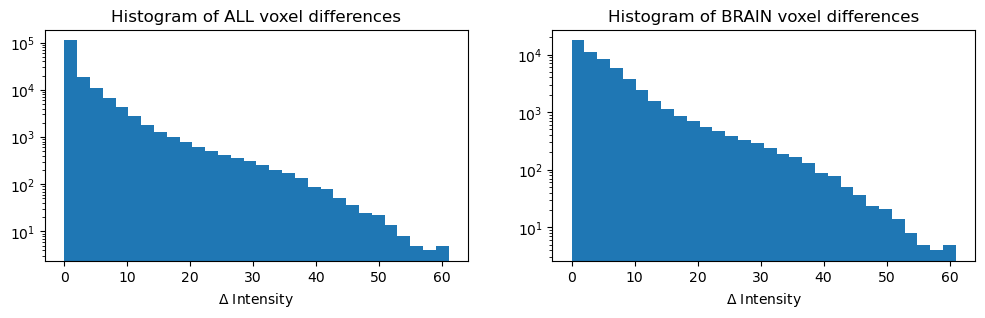

In [11]:
volume_bold = data_bold[:, :, :, volume_of_choice]
volume_moco = data_moco[:, :, :, volume_of_choice]
#Differences between bold and moco calculated by absolute difference
all_differences = np.abs(volume_bold.flatten() - volume_moco.flatten())
number_of_corrections = round(100*(1 - (len(all_differences[all_differences == 0])/len(all_differences))), 2)
display(f"% Voxels with non-null corrections: {number_of_corrections}")

brain_indices_bold = np.arange(len(volume_bold.flatten()))[volume_bold.flatten() > 100]
brain_indices_moco = np.arange(len(volume_bold.flatten()))[volume_moco.flatten() > 100]
brain_indices = np.unique(np.concatenate((brain_indices_bold, brain_indices_moco)))
brain_differences = np.abs(volume_bold.flatten()[brain_indices] - volume_moco.flatten()[brain_indices])

display(f"% Brain voxels with low intensity corrections (< 5): {round(100*((len(brain_differences[brain_differences < 5])/len(brain_differences))), 2)}")

fig, ax = plt.subplots(1, 2, figsize = (12, 3))

ax[0].hist(all_differences, bins= 30)
ax[0].set_title("Histogram of ALL voxel differences")
ax[0].set_xlabel("$\Delta$ Intensity")
ax[0].set_yscale("log")
ax[1].hist(brain_differences, bins=30)
ax[1].set_title("Histogram of BRAIN voxel differences")
ax[1].set_yscale("log")
ax[1].set_xlabel("$\Delta$ Intensity")

In [12]:
#Comparison of MOCO cost functions 
cost_functions = ["mutualinfo","woods","corratio","normcorr","normmi","leastsquares"]

run = 1
subject = "06"
sub = f'sub-{subject}'
rms_list = []
fd_list = []
for codx, cost_func in enumerate(cost_functions): 
    display(codx)
    path_original_data = os.path.join(bids_root, sub, 'func', f'{sub}_task-flanker_run-{run}_bold')
    path_moco_data = os.path.join(preproc_root, sub, 'func', f'{sub}_task-flanker_run-{run}_bold_moco_{cost_func}')
    #normcorr is default
    mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True, cost = cost_func)
    path = f'{sub}_task-flanker_run-{run}_bold_moco_{cost_func}.par'
    rms_list.append(calculate_rms_movement_path(path))
    params = load_mot_params_fsl_6_dof_path(path)
    fd_list.append(compute_FD_power(params).to_numpy())

0

1

2

3

4

5

In [17]:
moco_cost_comparison = pd.DataFrame( [rms_list, [np.mean(fd) for fd in fd_list]], columns = cost_functions, index = ["RMS", "Average FD"]).T
moco_cost_comparison

,RMS,Average FD
mutualinfo,0.094162,0.077112
woods,0.182136,0.177952
corratio,0.095800,0.088877
normcorr,0.095991,0.093267
normmi,0.095785,0.079037
leastsquares,0.099433,0.089022


Best performing cost function by average FD and RMS quality measures is mutualinfo, why?

4) For original data and motion-corrected data, visualise the time series for a voxel and report the differences you observe (if any) between the two.

(12, 60, 37)

Text(0, 0.5, 'Intensity')

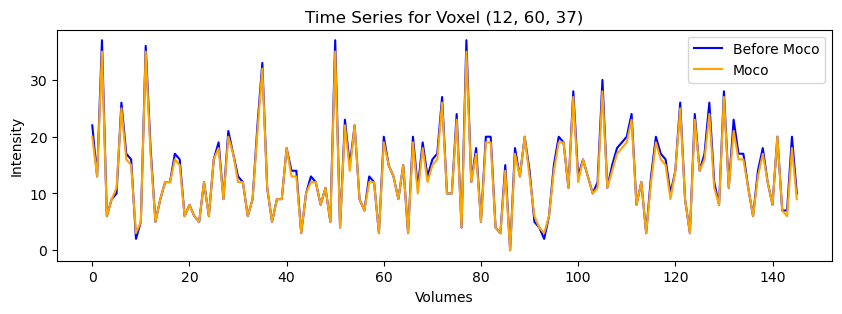

In [58]:
import nibabel as nib

# Load the image
img_bold = nib.load(os.path.join(bids_root, sub, 'func', 'sub-06_task-flanker_run-1_bold.nii.gz'))
img_moco = nib.load(os.path.join(preproc_root, sub, 'func', 'sub-06_task-flanker_run-1_bold_moco.nii.gz'))

# Get the data from the image
data_bold = img_bold.get_fdata()
data_moco=img_moco.get_fdata()

# Specify the voxel coordinates
random_voxel = tuple([np.random.randint(0, axs) for axs in data_bold.shape[:3]])
display(random_voxel)
x, y, z = random_voxel #randomoze

# Extract the time series for the voxel
time_series_bold = data_bold[x, y, z, :]
time_series_moco = data_moco[x, y, z, :]


# Plot the time series
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,3))
#axes[0].plot(time_series_bold, color='blue')
#axes[0].set_title(f'Time Series for Voxel {x, y, z}')
#axes[0].set_ylabel('Intensity')

# Plot the time series for the second voxel
#axes[1].plot(time_series_moco, color='green')
#axes[1].set_ylabel('Intensity')

axes.set_title(f'Time Series for Voxel {x, y, z}')
axes.plot(time_series_bold, color='blue', label='Before Moco')
axes.plot(time_series_moco, color='orange', label = 'Moco')
axes.legend()
axes.set_xlabel('Volumes')
axes.set_ylabel('Intensity') #scaling factor 

Good voxels: (19, 52, 11), (47, 20, 32), (33, 3, 22)

We see that motion correction for most voxels consists in a general shift in a intensity throughout the timeseries and it is minimal, therefore the 2 BOLD signals before and after MOCO are very similar as to not ruin the functional signal information.

5) Use a FSL command to generate a mean functional image and then use it as a reference image for motion correction (Hint: Use -refvol flag). Pick two more subjects. Compare motion correction results (motion parameters and FD) between the 3 subjects and report your observations.


In [59]:
bids_root, preproc_root = open_subject_dataset(dataset_id, subject='07', download=False)
bids_root, preproc_root = open_subject_dataset(dataset_id, subject='08', download=False)

default_cost_func = "normcorr"
best_cost_func = "mutualinfo"

In [6]:
perform_mean_moco(subject='06', cost_func = best_cost_func)
perform_mean_moco(subject='07', cost_func = best_cost_func)
perform_mean_moco(subject='08', cost_func = best_cost_func)

perform_default_moco(subject='06', cost_func = best_cost_func)
perform_default_moco(subject='07', cost_func = best_cost_func)
perform_default_moco(subject='08', cost_func = best_cost_func)

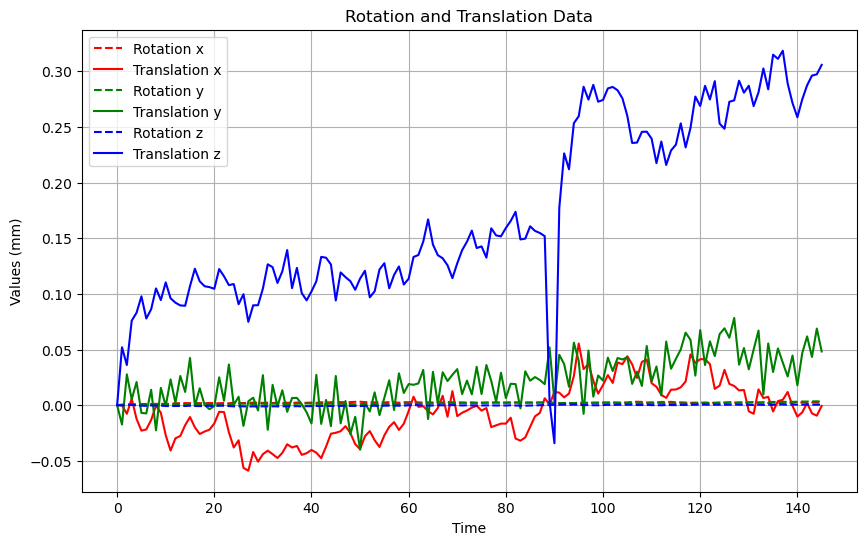

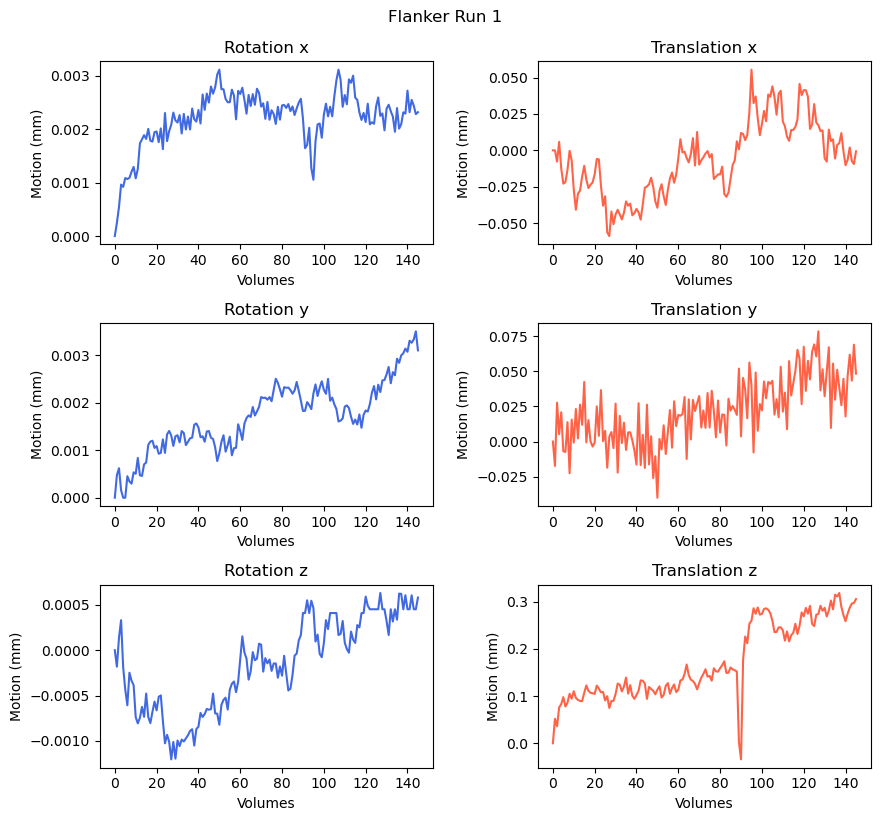

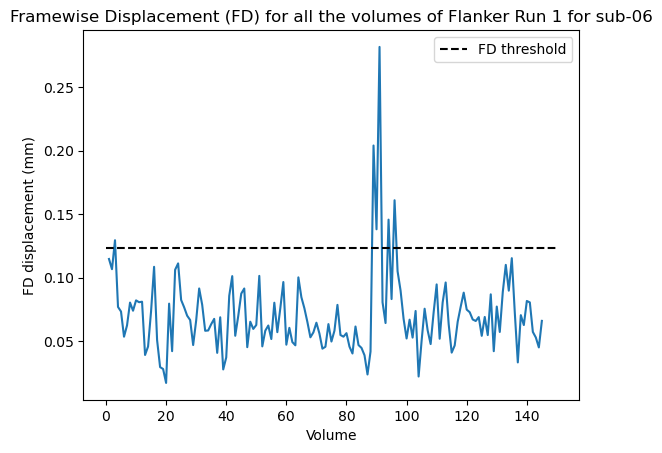

In [60]:
#Mean Visualization for subject 06
%matplotlib inline
mean_mot_params_06 = load_mean_mot_params_fsl_6_dof(subject='06', cost_func=best_cost_func)
visualize_motparams_oneplot(mean_mot_params_06)
visualize_motparams(mean_mot_params_06)
fd_06 = compute_FD_power(mean_mot_params_06).to_numpy()
visualise_fd(fd_06, subject='06')

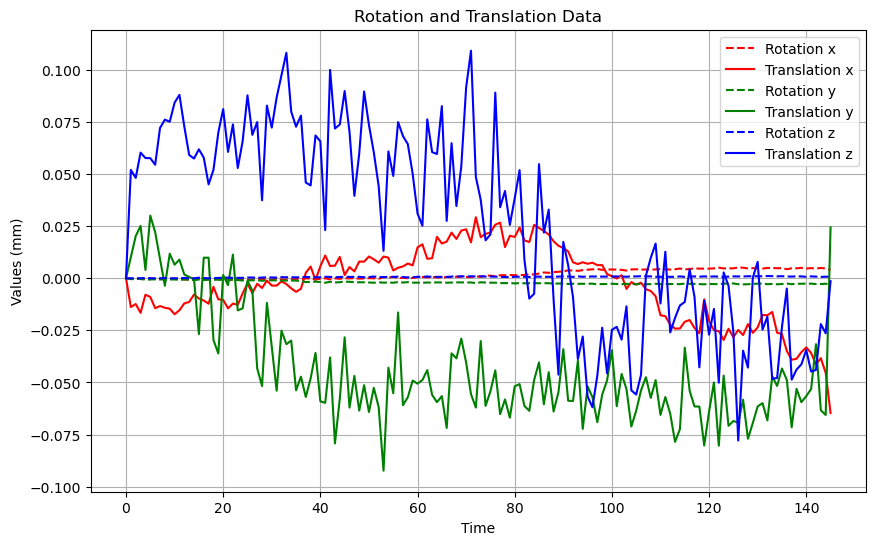

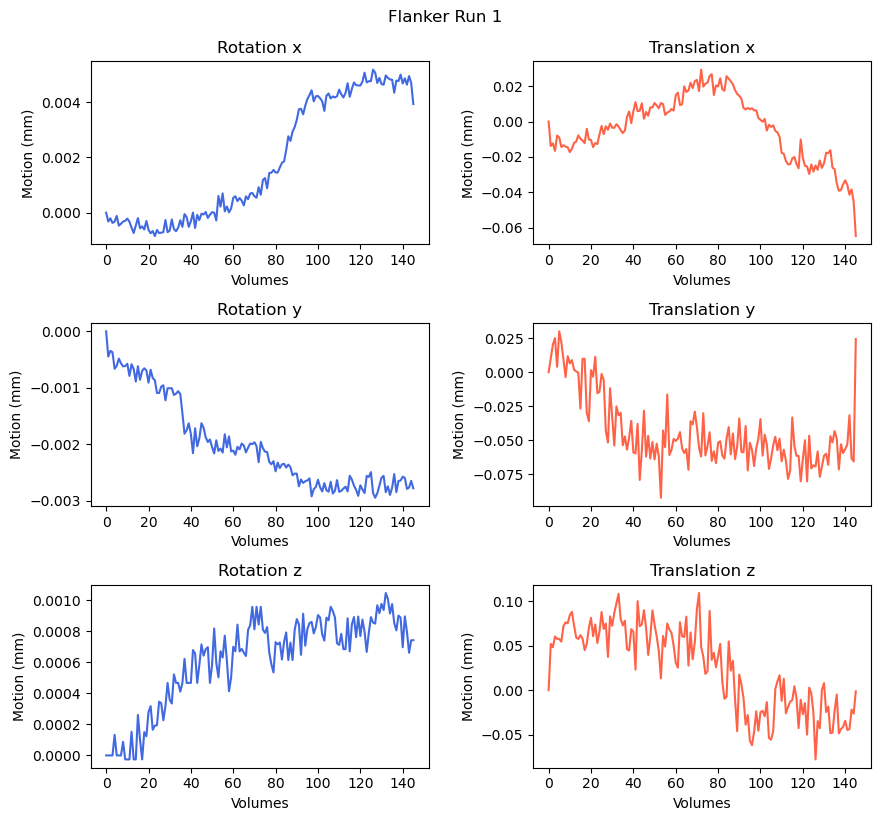

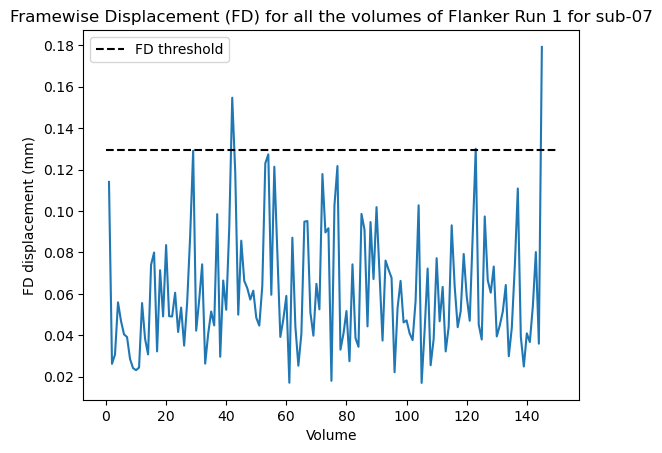

In [61]:
#Visualization for subject 07

mean_mot_params_07 = load_mean_mot_params_fsl_6_dof(subject='07', cost_func=best_cost_func)
visualize_motparams_oneplot(mean_mot_params_07)
visualize_motparams(mean_mot_params_07)
fd_07 = compute_FD_power(mean_mot_params_07).to_numpy()
visualise_fd(fd_07, subject='07')

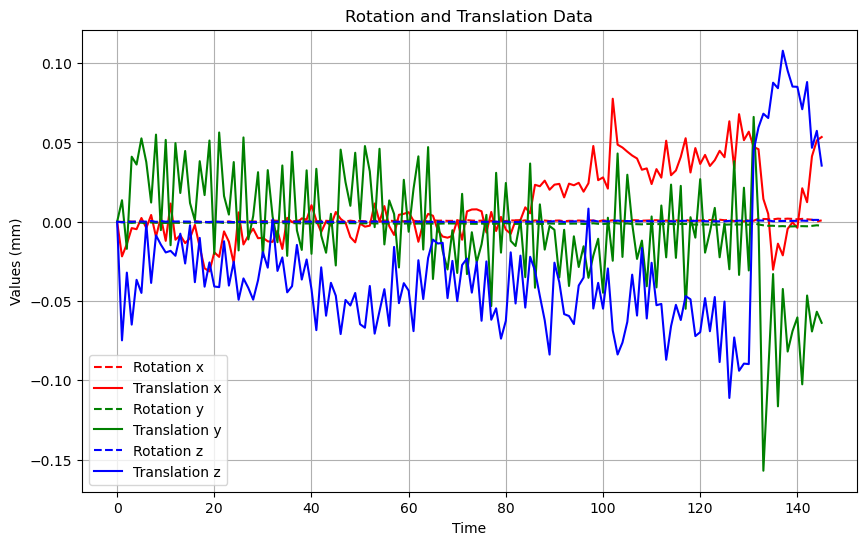

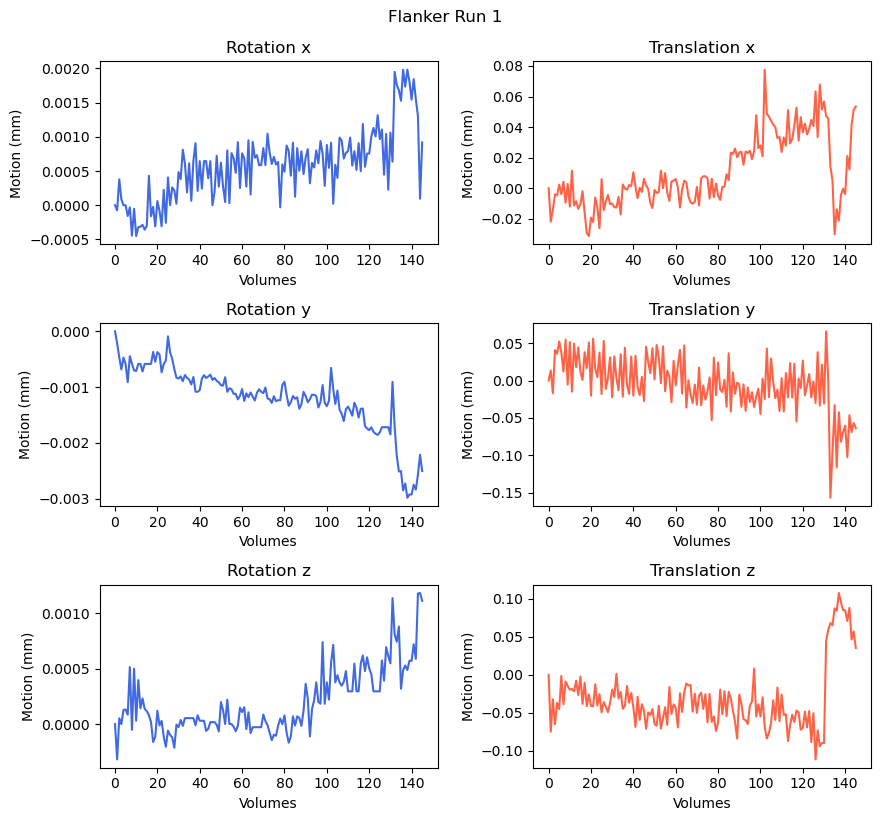

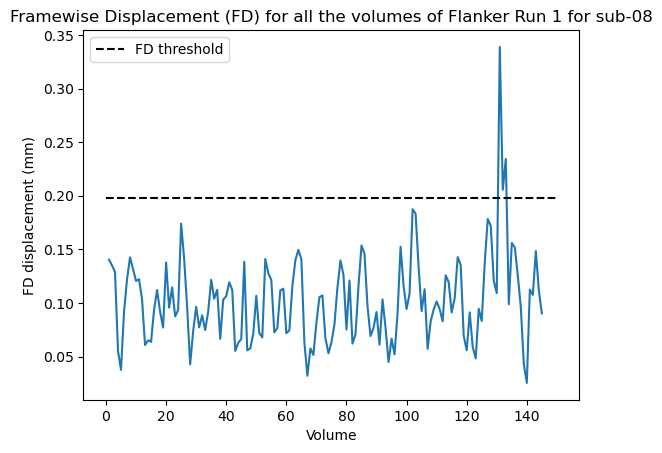

In [62]:
#Visualization for subject 08
mean_mot_params_08 = load_mean_mot_params_fsl_6_dof(subject='08', cost_func = best_cost_func)
visualize_motparams_oneplot(mean_mot_params_08)
visualize_motparams(mean_mot_params_08)
fd_08 = compute_FD_power(mean_mot_params_08).to_numpy()
visualise_fd(fd_08, subject='08')

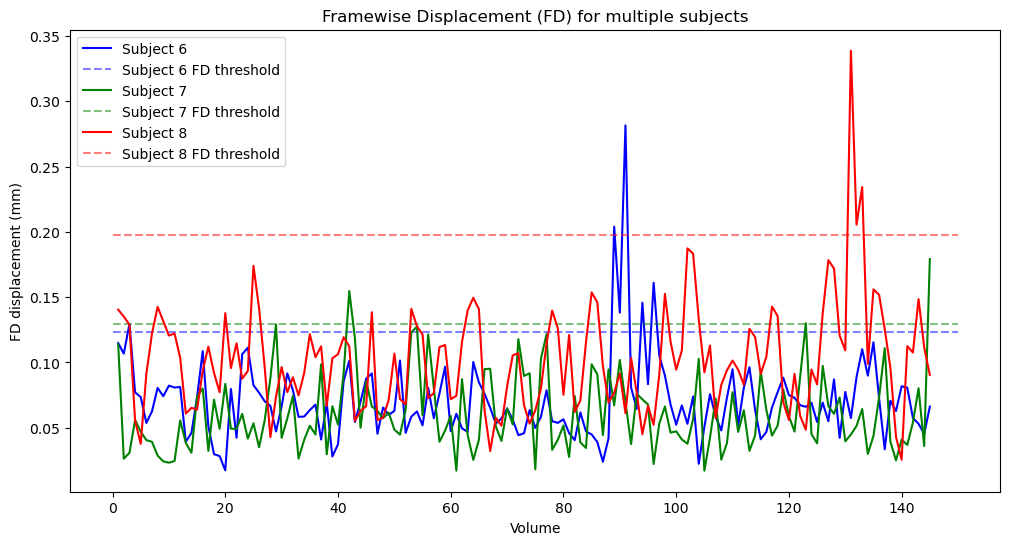

In [63]:

fd_runs = [fd_06, fd_07, fd_08]  
colors = ['b', 'g', 'r']
plt.figure(figsize=(12, 6))
thresholds = []
for i, fd in enumerate(fd_runs):
    thresholds.append( np.quantile(fd, 0.75) + 1.5 * (np.quantile(fd, 0.75) - np.quantile(fd, 0.25)))
    plt.plot(list(range(1, fd.size + 1)), fd, label=f'Subject {i + 6}', color=colors[i])
    plt.hlines(thresholds[i], 0, 150, colors=colors[i], linestyles='dashed', label=f'Subject {6+i} FD threshold', alpha= 0.5)

avg_thresh = np.mean(thresholds)
plt.title(f"Framewise Displacement (FD) for multiple subjects")
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
#plt.hlines(0.2, 0, len(fd_06), colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show() #show same the with middle and mean volume

## Bonus Part 

In [64]:
def calculate_DVARS(subject):
    sub = f'sub-{subject}'
    path_original_data = os.path.join(preproc_root, sub, 'func', f'{sub}_task-flanker_run-1_bold_moco_mean.nii.gz')
    output_image_path = os.path.join(preproc_root, sub, 'func', f'{sub}_task-flanker_run-{1}_bold_outliers')

    output_dvars = os.path.join(preproc_root, sub, 'func', f'{sub}_task-flanker_run-{1}_bold_moco_dvars')
    output_dvars_plot = os.path.join(preproc_root, sub, 'func', f'{sub}_task-flanker_run-{1}_bold_moco_dvars_plot')
    
    os.system("""fsl_motion_outliers -i {} -o {} --dvars -s {} -p {} --nomoco""".format(
        path_original_data, output_image_path, output_dvars, output_dvars_plot))
    return output_dvars

In [65]:
dvars_06 = calculate_DVARS("06")
dvars_07 = calculate_DVARS("07")
dvars_08 = calculate_DVARS("08")

## Two framewise indices of data quality, and a method for flagging frames of suspect quality

In [67]:
def data_quality(subject, output_dvars_path, fd):
    
    dvars = pd.read_csv(output_dvars_path).to_numpy().flatten()
    threshold_dvars = np.quantile(dvars,0.75) + 1.5*(np.quantile(dvars,0.75) - np.quantile(dvars,0.25))
    threshold_fd = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
    
    fig, ax = plt.subplots(3, 1, figsize = (10, 9), sharex = True)
    ax[0].plot(fd, color = "royalblue")
    ax[0].hlines(threshold_fd, xmin=0,xmax=len(dvars), color='deepskyblue', ls = "--")
    ax[0].set_ylabel("FD (mm)", fontweight = "bold") 
    ax[0].set_xlim(0, len(dvars))
    ax[1].plot(dvars, color = "tomato")
    ax[1].hlines(threshold_dvars, xmin=0,xmax=len(dvars), color="darkorange", ls = "--")
    ax[1].set_ylabel("DVARS", fontweight = "bold") 
    ax[1].set_xlim(0, len(dvars))
    volumes_fd = np.arange(len(dvars))[fd > threshold_fd]
    volumes_dvars =  np.arange(len(dvars))[dvars > threshold_dvars]
    outlier_volumes = np.unique(np.array(list(volumes_fd) +  list(volumes_dvars)))
    display(volumes_fd, volumes_dvars)
    ax[2].vlines(outlier_volumes, ymin = 0, ymax = 1, colors = "crimson", linewidth = 4)
    ax[2].set_ylim(0,1)
    ax[2].set_facecolor("moccasin")
    plt.xlabel("Volumes (TR = 2s)", fontweight = "bold")
    plt.suptitle(f"Motion Outliers for Subject {subject}")
    plt.savefig(f"dvars_{subject}.png", bbox_inches='tight')



array([ 2, 88, 89, 90, 93, 95])

array([ 0, 88, 89, 90])

array([ 41, 122, 144])

array([52])

array([130, 131, 132])

array([ 89,  98, 101, 143])

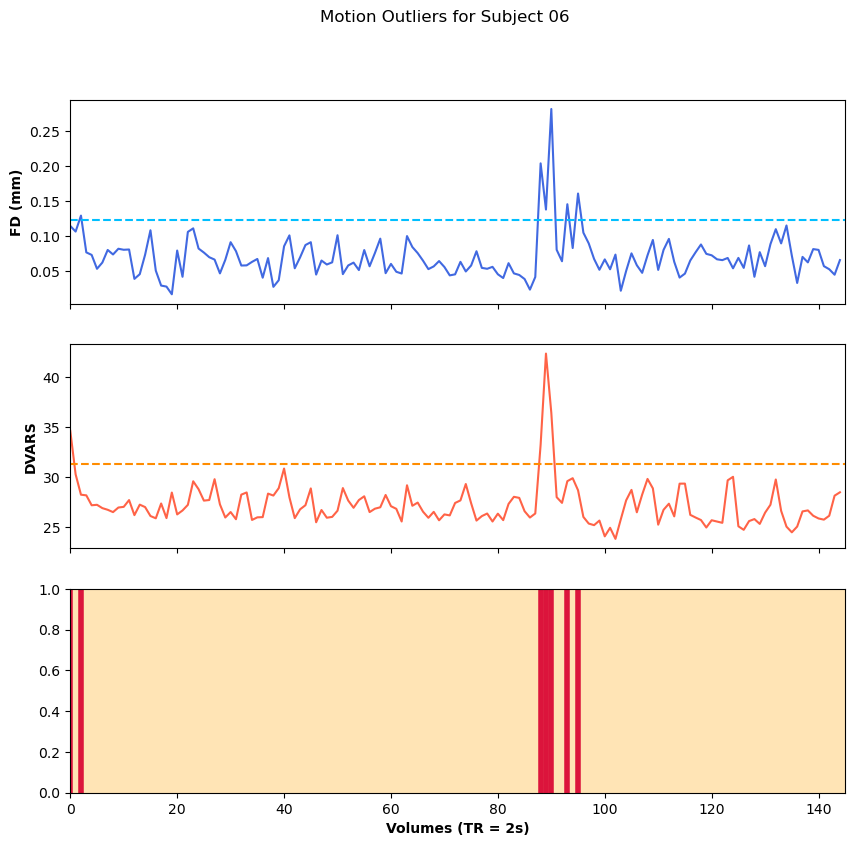

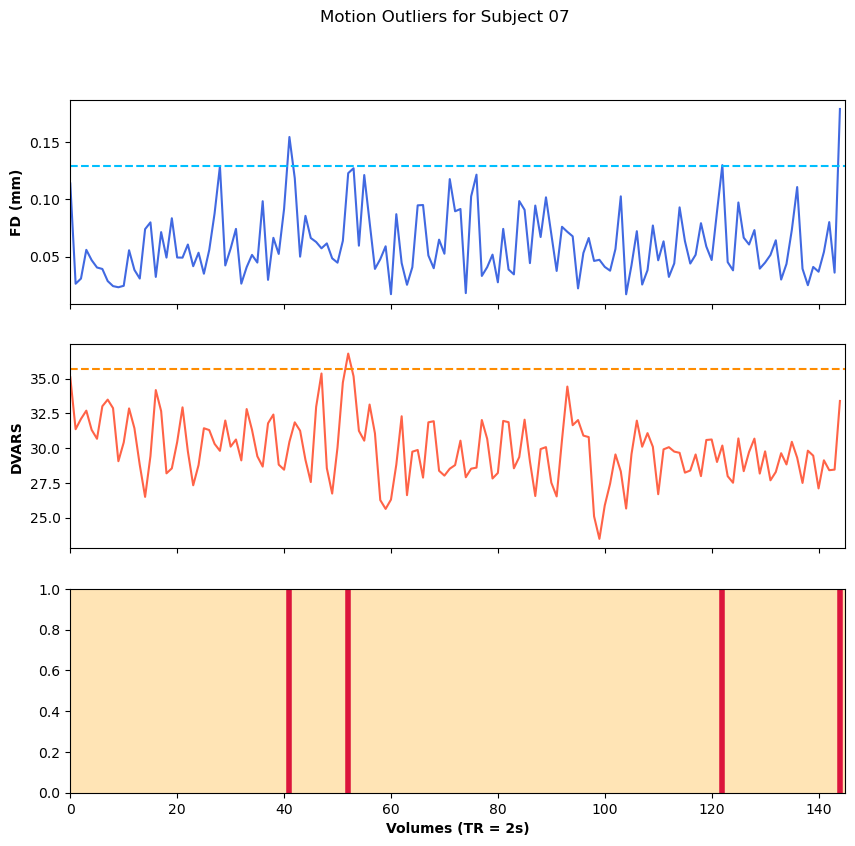

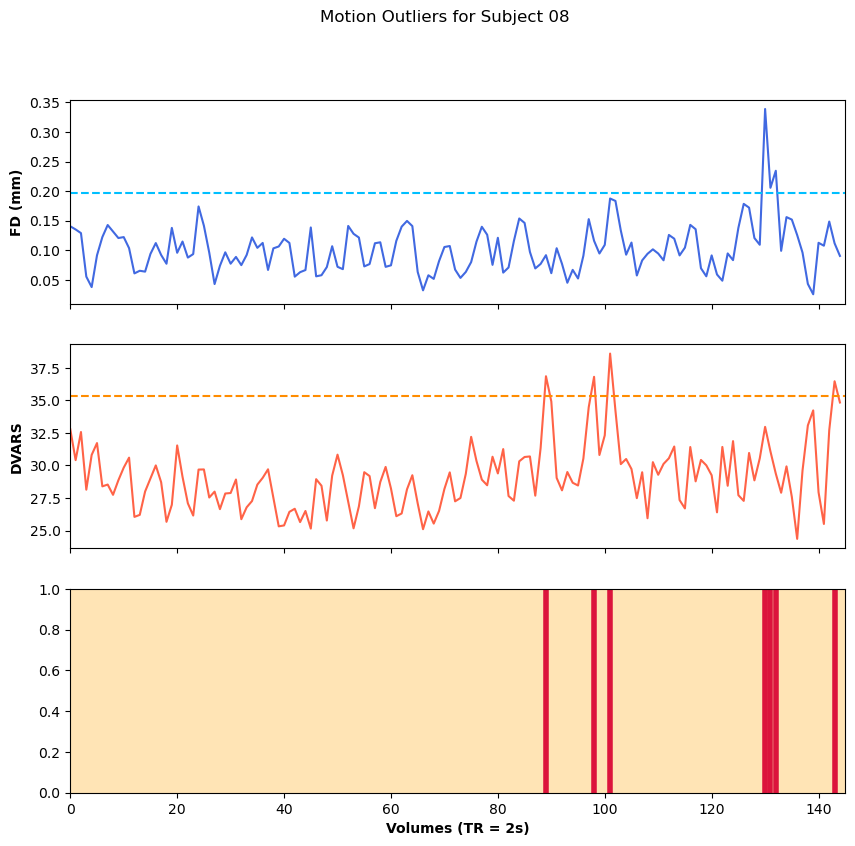

In [68]:
data_quality("06", dvars_06, fd_06)
data_quality("07", dvars_07, fd_07)
data_quality("08", dvars_08, fd_08) #dvars captures intensity changes and FD correlated to dvars values
#why is FD correlated

Bonus, tests

In [53]:
dataset_id = 'ds000102'
subject = '06' 
sub = 'sub-06'
sample_path = "dataset"

bids_root, preproc_root = open_subject_dataset(dataset_id, subject)
runs = 1
for r in range(runs):
    path_original_data = os.path.join(bids_root, sub, 'func', f'sub-06_task-flanker_run-{r+1}_bold.nii.gz')
    output_dvars_path = os.path.join(preproc_root, sub, 'func', f'sub-06_task-flanker_run-{r+1}_bold_dvars')
    output_moco_dvars_path = os.path.join(preproc_root, sub, 'func', f'sub-06_task-flanker_run-{r+1}_bold_moco_dvars')
    output_moco_dvars_plot_path = os.path.join(preproc_root, sub, 'func', f'sub-06_task-flanker_run-{r+1}_bold_moco_dvars_plot')
    os.system("""fsl_motion_outliers -i {} -o {} --dvars -s {} -p {}""".format(path_original_data, output_dvars_path, output_moco_dvars_path, output_moco_dvars_plot_path))

Loaded ds000102 for sub-06


In [56]:
with open(output_moco_dvars_path, 'r') as f:
    df = pd.read_csv(f)
    dvars = df.to_numpy().reshape(-1)
    print(dvars)

[33.7082 27.4209 25.2033 25.074  28.3236 32.8577 30.1504 26.8704 54.9656
 47.5516 28.032  25.4137 26.1218 24.4793 24.9584 26.275  28.4087 27.7022
 26.0194 26.3987 28.5129 28.0527 27.0442 27.4369 28.9689 28.1669 26.3326
 26.4916 27.3522 28.6215 28.3414 26.7626 25.5888 26.4788 26.2984 27.092
 26.5848 29.3678 27.3256 28.3628 27.2589 27.0721 27.6148 26.9337 29.67
 29.3658 28.0621 28.0296 28.6966 29.2771 28.9521 28.3502 29.5643 28.8141
 28.5048 28.6902 29.9668 31.2442 29.2729 27.8599 27.8587 29.8547 28.7394
 30.7515 27.6328 27.9243 27.94   28.1576 28.9473 27.9656 29.9093 29.6853
 29.0102 28.9609 29.8358 30.773  29.2825 28.2864 27.6025 27.7712 30.8925
 29.7179 27.569  27.4668 26.7245 26.8435 26.8869 29.564  30.0547 29.8252
 31.7911 29.006  29.0801 28.7579 27.7927 27.2842 27.1088 26.4147 26.8947
 29.0444 27.7134 31.5863 32.2709 29.6065 28.2821 27.3018 26.8652 27.377
 29.4746 28.5345 28.9422 28.3531 28.8667 27.3597 27.5516 26.9516 27.1549
 27.7287 27.6978 26.974  29.3903 28.6517 26.3707 26.771

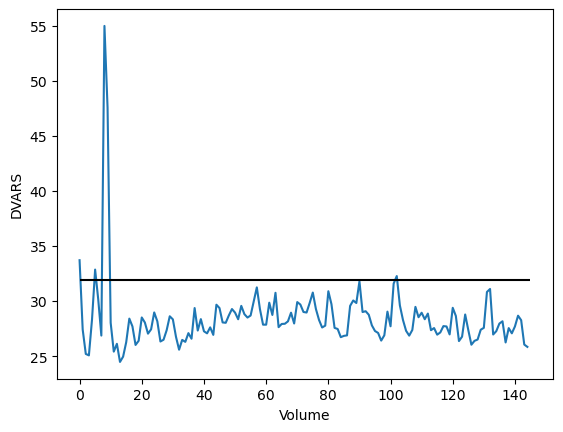

In [64]:
threshold_dvars = np.quantile(dvars,0.75) + 1.5*(np.quantile(dvars,0.75) - np.quantile(dvars,0.25))
plt.plot(dvars)
plt.hlines(threshold_dvars, xmin=0,xmax=len(dvars), color='k')
plt.ylabel('DVARS')
plt.xlabel('Volume')
plt.show()